In [9]:
import numpy as np
import matplotlib.pyplot as plt
import scipy 
from scipy.integrate import odeint
import matplotlib as mpl
mpl.rcParams.update({'font.size': 20, 
            'text.usetex': True, 'font.family': 'serif', 'font.serif': ['Computer Modern']})
%matplotlib widget

Solving RCSJ differential equation for phase of conventional Josephson junction with CPR:
$$ I(\varphi) = I_{C} \sin(\varphi) $$
The unitless differential equation for  is given by
$$ \ddot{\varphi} + Q^{-1}\dot{\varphi} + \sin(\varphi) = i_{b} $$
where $Q = \omega_{p}RC$, $i_{b} = I_{B} / I_{C}$ is the dimensionless bias current which tilts the washboard potential and time is given in units of inverse Josephson plasma frequency $\omega_{p}^{-1}$.

In [2]:
# Simulation parameters:
T = 1e4 # Time taken for bias current to ramp up to maximum value.
Q =  3 # Quality factor oscillator: Q > 1/2 places us in the underdamped regime.
dt = 0.01 # Time-step
i_b_max = 1.5 # Maximum bias current. i_b = 1 corresponds to the critical current of the junction.
avwindow = 100 # Number of steps to average voltage over.

# Initial conditions:
phi_0 = 0.0
v_0 = 0.0 # v =frac{d\phi}{dt}
y_0 = np.array([phi_0 , v_0])

In [3]:
from scipy import signal
t = np.linspace(0 , 4*T , int(4*T/dt))
biascurrent = i_b_max*signal.sawtooth((2*np.pi*(t - T))/(4*T) , 0.5)

def RCSJ(y , t, Q , i_b_max , T):
    phi = y[0]
    v = y[1]
    dydt = np.array([v , -(1/Q)*v - np.sin(phi) + i_b_max*scipy.signal.sawtooth((2*np.pi*(t - T))/(4*T) , 0.5)])
    return dydt

sol = odeint(RCSJ , y_0 , t , args = (Q , i_b_max , T))


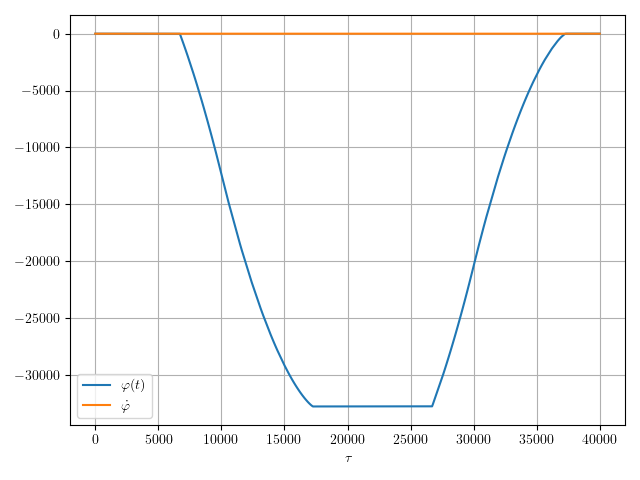

In [4]:
fig  , ax = plt.subplots()
plt.plot(t , sol[: , 0] , label = r'$\varphi(t)$')
plt.plot(t , sol[: , 1]  , label = r'$\dot{\varphi}$')
plt.xlabel(r'$\tau$')
plt.grid()
plt.legend()
plt.tight_layout()

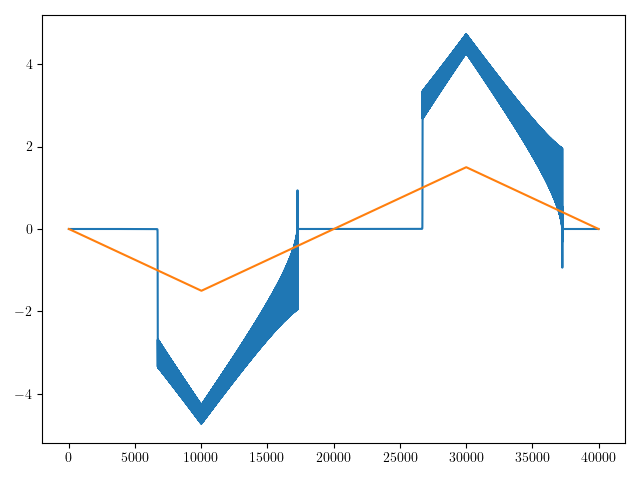

In [5]:
from scipy import signal
plt.figure()
averagewindow = 100
plt.plot(t , sol[: , 1])
plt.plot(t , i_b_max*scipy.signal.sawtooth((2*np.pi*(t - T))/(4*T) , 0.5))
plt.tight_layout()

4000000
4000000


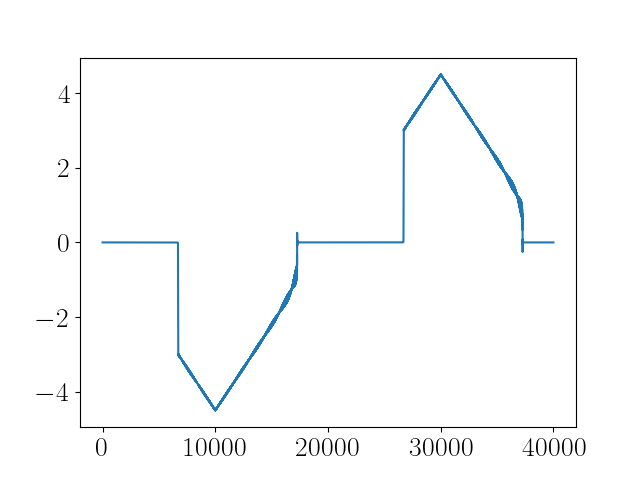

In [11]:
# Average voltage over several time steps
vav = np.convolve(sol[: , 1] , np.ones(10000)/1000 , mode = 'same')
print(len(t))
print(len(vav))

fig , ax = plt.subplots()
ax.plot(t , vav)

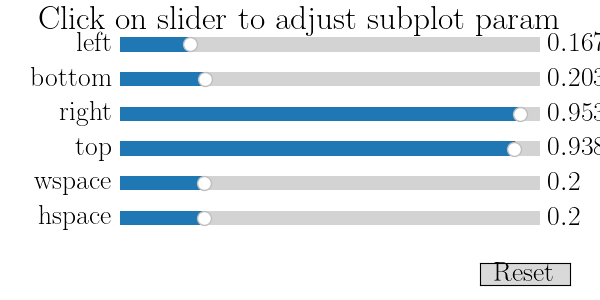

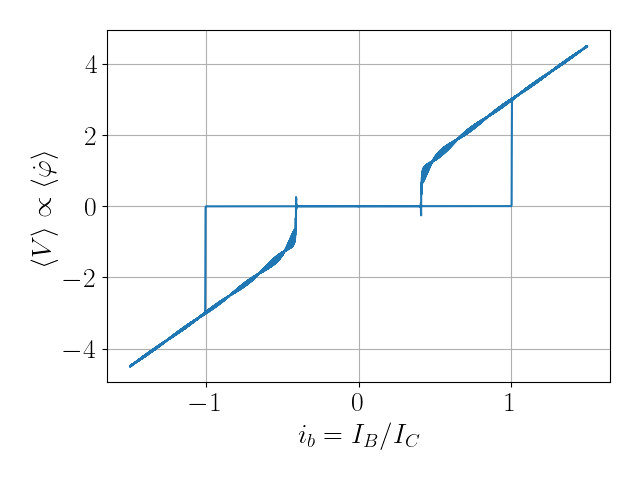

In [18]:
# Plotting I-V characteristic
fig , ax = plt.subplots()
ax.plot(biascurrent , vav)
ax.set_xlabel(r'$i_{b} = I_{B}/I_{C}$')
ax.set_ylabel(r'$\langle V\rangle \propto \langle \dot{\varphi} \rangle $')
plt.tight_layout()
plt.subplot_tool()
plt.grid()



Great so we are able to see switching and retrapping behaviour!

Now we can play with assymmetry in the current phase relation:
$$ i_{J}(\varphi) = c_{1}\left[ \sin(\varphi - \tilde{\varphi})  - c_{2} \sin(2\varphi)\right] $$
$$ i_{d}(\varphi) = \frac{v}{Q}\left[ 1 + c_{3}\left(\frac{v}{\delta v}\right)\exp\left\{\frac{-1}{2}\left(\frac{v^2}{\delta v^2} - 1\right) \right\} \right]$$
This should yield non-reciprocity in the switching currents, not the retrapping currents...

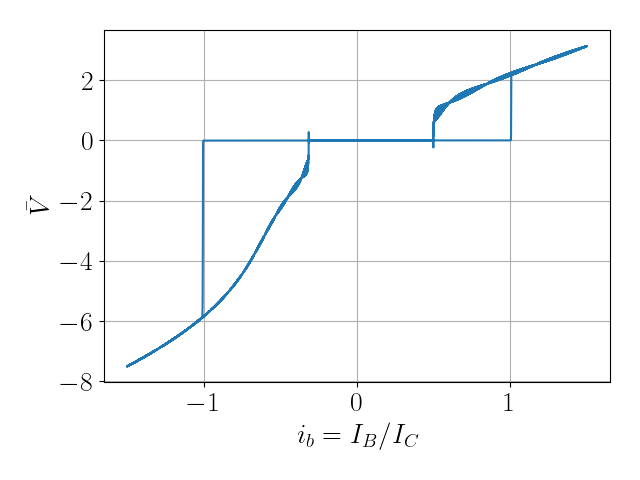

In [22]:
def RCSJ_asymCPR(y , t, c_1 , c_2, c_3 , q , dv, phi_tilde, Q , i_b_max , T):
    phi = y[0]
    v = y[1]
    # Assymmetric current phase relationship: 
    asym_CPR = c_1*(np.sin(phi - phi_tilde) - c_2*np.sin(2*phi))

    # Dissipative term:
    i_d = (v/q)*(1 + c_3*(v/dv)*np.exp(-0.5*((v/dv)**2 -1 )))
    dydt = np.array([v , -i_d - asym_CPR + i_b_max*scipy.signal.sawtooth((2*np.pi*(t - T))/(4*T) , 0.5)])
    return dydt

c_1 = 1
c_2 = 0.0
c_3 = 0.5
dv = 5
q = Q
phi_tilde = 0.0
sol_asym_CPR = odeint(RCSJ_asymCPR , y_0 , t , args = (c_1 , c_2 , c_3 , q , dv, phi_tilde, Q , i_b_max , T))
# Plotting I-V characteristic
fig , ax = plt.subplots()
ax.plot(biascurrent ,np.convolve(sol_asym_CPR[: , 1] , np.ones(1000)/1000 , mode = 'same') )
ax.set_xlabel(r'$i_{b} = I_{B}/I_{C}$')
ax.set_ylabel(r'$\bar{V} $')
plt.grid()
plt.tight_layout()

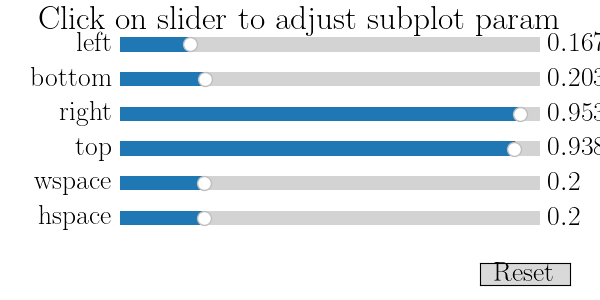

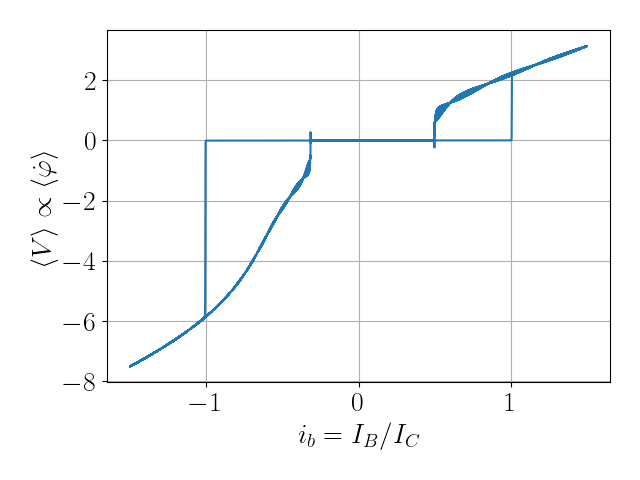

In [23]:
fig , ax = plt.subplots()
ax.plot(biascurrent ,np.convolve(sol_asym_CPR[: , 1] , np.ones(1000)/1000 , mode = 'same') )
ax.set_xlabel(r'$i_{b} = I_{B}/I_{C}$')
ax.set_ylabel(r'$\langle V\rangle \propto \langle \dot{\varphi} \rangle $')
plt.grid()
plt.tight_layout()
plt.subplot_tool()